# DIGI405-20S1 - Topic Modeling TED.com transcripts

This notebook introduces Gensim for topic modeling. The 2018 TED.com transcripts are also available for download on the datasets page on Learn if you wish to train models using TMT.

Work through the notebook. The key things to do are:
1. to try training some different size models (e.g. 10 topics, 30 topics, 50 topics);  
2. to explore the topic assignments for documents and assess the quality of topics returned; 
3. to measure 'c_v' topic coherence for a number of models;
3. to make notes on your observations of different models and the kinds of similarities between documents they produce.

Since we need to evaluate topic models against a use case - think about the idea of a recommendation engine: what model performs best for finding similiar TED talks?

In [1]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import pandas as pd
import matplotlib.pyplot as plt

mallet_path = '/opt/mallet-2.0.8/bin/mallet' # this should be the correct path for the DIGI405 lab workrooms

In [2]:
# to install nltk run this in Anaconda prompt: pip install nltk 
# note if you get an error with stopwords below then uncomment the following lines and rerun this cell 
import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /homedirs/tmn52/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The following cells contain functions to load a corpus from a directory of text files, preprocess the corpus and create the bag of words document-term matrix. 

In [3]:
def load_data_from_dir(path):
    file_list = glob.glob(path + '/*.txt')

    # create document list:
    documents_list = []
    source_list = []
    for filename in file_list:
        with open(filename, 'r', encoding='utf8') as f:
            text = f.read()
            f.close()
            documents_list.append(text)
            source_list.append(os.path.basename(filename))
    print("Total Number of Documents:",len(documents_list))
    return documents_list, source_list


In [4]:
def preprocess_data(doc_set,extra_stopwords = {}):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # replace all newlines or multiple sequences of spaces with a standard space
    doc_set = [re.sub('\s+', ' ', doc) for doc in doc_set]
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # add any extra stopwords
    if (len(extra_stopwords) > 0):
        en_stop = en_stop.union(extra_stopwords)
    
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # add tokens to list
        texts.append(stopped_tokens)
    return texts

In [5]:
def prepare_corpus(doc_clean):
    # adapted from https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    return dictionary,doc_term_matrix

## Load and pre-process the corpus
Load the corpus, preprocess with additional stop words and output dictionary and document-term matrix.

In [6]:
# adjust the path below to wherever you have the transcripts2018 folder
document_list, source_list = load_data_from_dir("transcripts/")

# I've added extra stopwords here in addition to NLTK's stopword list - you could look at adding others.
doc_clean = preprocess_data(document_list,{'laughter','applause', 'space', 'love', '000', 'ca'})

dictionary, doc_term_matrix = prepare_corpus(doc_clean)

Total Number of Documents: 3603


## Test a range of topic sizes and plot the results

**Important**: this process will take a while to run! Make sure you have tried a number topic sizes to get a sense of what models you need to test. I suggest you test no more than 8-10 models using the code below, so as not to be waiting too long!

In [7]:
# supply values for k and the interval, eg 20, 60, 10 will train models for 20, 30, 40, 50, and 60 topics
min_k = 20
max_k = 60
intervals = 5

coherences = {}
ldamalletmodel_list = []
gensimmodel_list = []

for i in range(min_k, max_k, intervals):
    ldamalletmodel = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=i, id2word=dictionary)
    ldamalletmodel_list.append(ldamalletmodel)
    gensimmodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamalletmodel)
    gensimmodel_list.append(gensimmodel)
    coherences[i] = CoherenceModel(model=gensimmodel, texts=doc_clean, dictionary=dictionary, coherence='c_v').get_coherence()

In [8]:
# convert the coherence scores to a pandas dataframe
df = pd.DataFrame.from_dict(coherences, orient='index', columns=['Coherence'])
df['Topics'] = df.index

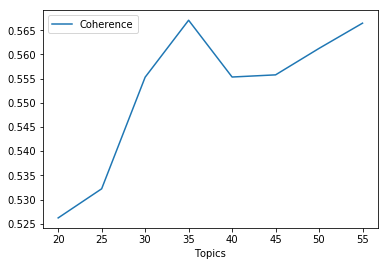

In [9]:
# plot the result
df.plot(kind='line', x='Topics', y='Coherence')

In [10]:
coherences

{20: 0.5261953544774354,
 25: 0.5322146887573581,
 30: 0.5552787119678679,
 35: 0.567054594115017,
 40: 0.55531899920455,
 45: 0.555765433987607,
 50: 0.5612377243381319,
 55: 0.5664517402015053}

In [11]:
ldamalletmodel_list[3].show_topics(num_topics=40,num_words=20)

[(0,
  '0.017*"social" + 0.012*"question" + 0.010*"study" + 0.008*"choice" + 0.007*"behavior" + 0.007*"group" + 0.007*"human" + 0.006*"reason" + 0.006*"answer" + 0.006*"wrong" + 0.006*"research" + 0.006*"society" + 0.006*"choices" + 0.006*"decisions" + 0.006*"questions" + 0.006*"asked" + 0.005*"makes" + 0.005*"bad" + 0.005*"moral" + 0.005*"evidence"'),
 (1,
  '0.014*"change" + 0.011*"working" + 0.009*"team" + 0.008*"idea" + 0.008*"community" + 0.007*"create" + 0.007*"ideas" + 0.007*"start" + 0.006*"important" + 0.006*"success" + 0.006*"problems" + 0.006*"process" + 0.006*"organization" + 0.005*"build" + 0.005*"business" + 0.005*"trust" + 0.005*"impact" + 0.005*"social" + 0.005*"leaders" + 0.005*"support"'),
 (2,
  '0.026*"black" + 0.016*"white" + 0.014*"law" + 0.013*"police" + 0.011*"justice" + 0.009*"prison" + 0.008*"states" + 0.007*"american" + 0.007*"america" + 0.007*"case" + 0.007*"rights" + 0.007*"crime" + 0.007*"legal" + 0.007*"court" + 0.006*"community" + 0.006*"race" + 0.005*"v

In [12]:
lookup_doc_id1 = source_list.index('2018-03-03-kriti_sharma_how_to_keep_human_biases_out_of_ai.txt')
print('Document ID from lookup:', lookup_doc_id1)

Document ID from lookup: 1082


In [13]:
lookup_doc_id2 = source_list.index('2012-09-14-timothy_bartik_the_economic_case_for_preschool.txt')
print('Document ID from lookup:', lookup_doc_id2)

Document ID from lookup: 136


## Preview a document

Preview a document - you can change the doc_id to view another document.

In [14]:
doc_id1 = lookup_doc_id1 # index of document to explore
print(re.sub('\s+', ' ', document_list[doc_id1])) 

How many decisions have been made about you today, or this week or this year, by artificial intelligence? I build AI for a living so, full disclosure, I'm kind of a nerd. And because I'm kind of a nerd, wherever some new news story comes out about artificial intelligence stealing all our jobs, or robots getting citizenship of an actual country, I'm the person my friends and followers message freaking out about the future. We see this everywhere. This media panic that our robot overlords are taking over. We could blame Hollywood for that. But in reality, that's not the problem we should be focusing on. There is a more pressing danger, a bigger risk with AI, that we need to fix first. So we are back to this question: How many decisions have been made about you today by AI? And how many of these were based on your gender, your race or your background? Algorithms are being used all the time to make decisions about who we are and what we want. Some of the women in this room will know what I

## Output the distribution of topics for the document

The next cell outputs the distribution of topics on the document specified above.

In [15]:
document_topics = gensimmodel_list[3].get_document_topics(doc_term_matrix[doc_id1]) # substitute other models here
document_topics = sorted(document_topics, key=lambda x: x[1], reverse=True) # sorts document topics

for topic, prop in document_topics:
    topic_words = [word[0] for word in gensimmodel_list[3].show_topic(topic, 20)]
    print ("%.2f" % prop, topic, topic_words)

0.18 18 ['technology', 'human', 'car', 'future', 'machine', 'cars', 'machines', 'system', 'intelligence', 'problem', 'technologies', 'power', 'computer', 'driving', 'humans', 'drive', 'build', 'ai', 'computers', 'artificial']
0.14 19 ['women', 'men', 'woman', 'girls', 'sex', 'gender', 'female', 'male', 'man', 'sexual', 'talk', 'young', 'girl', 'boys', 'gay', 'told', 'culture', 'talking', 'marriage', 'violence']
0.11 22 ['data', 'information', 'internet', 'online', 'phone', 'technology', 'google', 'digital', 'web', 'media', 'network', 'facebook', 'open', 'computer', 'access', 'content', 'mobile', 'code', 'software', 'networks']
0.09 1 ['change', 'working', 'team', 'idea', 'community', 'create', 'ideas', 'start', 'important', 'success', 'problems', 'process', 'organization', 'build', 'business', 'trust', 'impact', 'social', 'leaders', 'support']
0.08 0 ['social', 'question', 'study', 'choice', 'behavior', 'group', 'human', 'reason', 'answer', 'wrong', 'research', 'society', 'choices', 'd

## Find similar documents
This will find the 5 most similar documents to the document specified above based on their topic distribution. The MatrixSimilarity() method uses cosine similarity to measure how similar the document specified by `docid` is to all other documents for that model. There are better measures, but this one is quick and simple to implement.

In [16]:
model_doc_topics = gensimmodel_list[3].get_document_topics(doc_term_matrix) # substitute other models here
lda_index = similarities.MatrixSimilarity(model_doc_topics.corpus)
    
# query for our doc_id from above
similarity_index = lda_index[doc_term_matrix[doc_id1]]
# Sort the similarity index
similarity_index = sorted(enumerate(similarity_index), key=lambda item: -item[1])

for i in range(8,11): 
    document_id, similarity_score = similarity_index[i]
    print('Document Index: ',document_id)
    print('Document:', source_list[document_id])
    print('Similarity Score',similarity_score)
    print(re.sub('\s+', ' ', document_list[document_id][:500]), '...') # preview first 500 characters
    
    document_topics1 = gensimmodel_list[3].get_document_topics(doc_term_matrix[document_id])
    document_topics1 = sorted(document_topics1, key=lambda x: x[1], reverse=True)
    for topic, prop in document_topics1:
        topic_words = [word[0] for word in gensimmodel_list[3].show_topic(topic, 20)]
        print ("%.2f" % prop, topic, topic_words)
    
    print()

Document Index:  752
Document: 2017-12-06-raphael_arar_how_we_can_teach_computers_to_make_sense_of_our_emotions.txt
Similarity Score 0.2987894
I consider myself one part artist and one part designer. And I work at an artificial intelligence research lab. We're trying to create technology that you'll want to interact with in the far future. Not just six months from now, but try years and decades from now. And we're taking a moonshot that we'll want to be interacting with computers in deeply emotional ways. So in order to do that, the technology has to be just as much human as it is artificial. It has to get you. You know, like that insi ...
0.15 14 ['feel', 'experience', 'feeling', 'fear', 'mind', 'person', 'lives', 'talk', 'happy', 'live', 'happiness', 'felt', 'friends', 'emotional', 'pain', 'moment', 'emotions', 'face', 'experiences', 'feelings']
0.15 18 ['technology', 'human', 'car', 'future', 'machine', 'cars', 'machines', 'system', 'intelligence', 'problem', 'technologies', 'power'

## Preview a document

Preview a document - you can change the doc_id to view another document.

In [17]:
doc_id2 = lookup_doc_id2# index of document to explore
print(re.sub('\s+', ' ', document_list[doc_id2])) 

In this talk today, I want to present a different idea for why investing in early childhood education makes sense as a public investment. It's a different idea, because usually, when people talk about early childhood programs, they talk about all the wonderful benefits for participants in terms of former participants, in preschool, they have better K-12 test scores, better adult earnings. Now that's all very important, but what I want to talk about is what preschool does for state economies and for promoting state economic development. And that's actually crucial because if we're going to get increased investment in early childhood programs, we need to interest state governments in this. The federal government has a lot on its plate, and state governments are going to have to step up. So we have to appeal to them, the legislators in the state government, and turn to something they understand, that they have to promote the economic development of their state economy. Now, by promoting e

## Output the distribution of topics for the document

The next cell outputs the distribution of topics on the document specified above.

In [18]:
document_topics = gensimmodel_list[3].get_document_topics(doc_term_matrix[doc_id2]) # substitute other models here
document_topics = sorted(document_topics, key=lambda x: x[1], reverse=True) # sorts document topics

for topic, prop in document_topics:
    topic_words = [word[0] for word in gensimmodel_list[3].show_topic(topic, 20)]
    print ("%.2f" % prop, topic, topic_words)

0.31 34 ['money', 'dollars', 'business', 'companies', 'company', 'market', 'buy', 'pay', 'industry', 'cost', 'jobs', 'economy', 'percent', 'product', 'financial', 'sell', 'economic', 'million', 'costs', 'price']
0.20 7 ['school', 'kids', 'students', 'education', 'learning', 'learn', 'high', 'children', 'schools', 'class', 'teachers', 'teach', 'student', 'college', 'teacher', 'young', 'university', 'teaching', 'kid', 'skills']
0.16 0 ['social', 'question', 'study', 'choice', 'behavior', 'group', 'human', 'reason', 'answer', 'wrong', 'research', 'society', 'choices', 'decisions', 'questions', 'asked', 'makes', 'bad', 'moral', 'evidence']
0.06 33 ['countries', 'africa', 'country', 'china', 'india', 'global', 'growth', 'economic', 'poverty', 'african', 'states', 'chinese', 'population', 'poor', 'united', 'percent', 'development', 'billion', 'south', 'income']
0.05 5 ['percent', 'number', 'million', '10', '1', '2', 'times', '100', 'half', '30', '20', 'numbers', '50', '3', '15', '5', 'ago', 

## Find similar documents
This will find the 5 most similar documents to the document specified above based on their topic distribution. The MatrixSimilarity() method uses cosine similarity to measure how similar the document specified by `docid` is to all other documents for that model. There are better measures, but this one is quick and simple to implement.

In [50]:
model_doc_topics = gensimmodel_list[3].get_document_topics(doc_term_matrix) # substitute other models here
lda_index = similarities.MatrixSimilarity(model_doc_topics.corpus)
    
# query for our doc_id from above
similarity_index = lda_index[doc_term_matrix[doc_id2]]
# Sort the similarity index
similarity_index = sorted(enumerate(similarity_index), key=lambda item: -item[1])

for i in range(7,10): 
    document_id, similarity_score = similarity_index[i]
    print('Document Index: ',document_id)
    print('Similarity Score',similarity_score)
    print(re.sub('\s+', ' ', document_list[document_id][:700]), '...') # preview first 500 characters
    
    document_topics2 = gensimmodel_list[3].get_document_topics(doc_term_matrix[document_id])
    document_topics2 = sorted(document_topics2, key=lambda x: x[1], reverse=True)
    for topic, prop in document_topics2:
        topic_words = [word[0] for word in gensimmodel_list[3].show_topic(topic, 20)]
        print ("%.2f" % prop, topic, topic_words)
    
    print()

Document Index:  1344
Similarity Score 0.23183876
I'm the product of a bold leadership decision. After 1956, when Tunisia became independent, our first president, Habib Bourguiba, decided to invest 20 percent of the country's national budget in education. Yes, 20 percent, on the high end of the spectrum even by today's standards. Some people protested. What about infrastructure? What about electricity, roads and running water? Are these not important? I would argue that the most important infrastructure we have are minds, educated minds. President Bourguiba helped establish free, high-quality education for every boy and every girl. And together with millions of other Tunisians, I'm deeply indebted to that historic decision. And that's wha ...
0.32 12 ['school', 'kids', 'students', 'education', 'learning', 'high', 'learn', 'schools', 'teach', 'class', 'teachers', 'college', 'teacher', 'student', 'young', 'children', 'university', 'skills', 'teaching', 'learned']
0.20 30 ['countries', 'a